In [1]:
"""Temporary fix for importing modules from parent directory"""
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.integrator import DelIntegrator as DI

In [3]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import casadi as cs
import numpy as np

In [4]:
t0, tf, steps = 0.0, 10.0, 1000
dt = (tf - t0) / steps
m = 1
g = 9.8

In [5]:
q = cs.SX.sym('q', 1)
v = cs.SX.sym('v', 1)
I = m

kinetic = cs.Function(
    'kinetic', [q, v], [0.5 * v.T @ I * v]
)
potential = cs.Function(
    'potential', [q], [-m * g * (1 - cs.cos(q))]
)
lagrangian = cs.Function(
    'lagrangian', [q, v], [kinetic(q, v) - potential(q)]
)

In [6]:
di = DI(
    nq=1,
    nu=0,
    lagrangian=lagrangian,
)

In [7]:
def simulate(q_0=0, v_0=0):
    qs_sol = np.zeros((steps, 1))
    qs_sol[0] = q_0
    qs_sol[1] = q_0 + v_0 * dt

    for i in range(2, steps):
        q0 = qs_sol[i - 2]
        q1 = qs_sol[i - 1]

        qs_sol[i] = di.step(q0, q1, dt)
    
    vs_sol = np.zeros((steps, 1))
    for i in range(1, steps):
        vs_sol[i] = (qs_sol[i] - qs_sol[i - 1]) / dt

    Ks = np.zeros((steps, 1))
    Ps = np.zeros((steps, 1))
    for i in range(steps):
        Ks[i] = kinetic(qs_sol[i], vs_sol[i])
        Ps[i] = potential(qs_sol[i])

    Ks[0] = v_0 ** 2 * m / 2
    return qs_sol, vs_sol, Ks, Ps

In [8]:
# Initial angles for simulation
initial_angles = np.linspace(np.pi / 6, np.pi / 6, 1)
initial_velocities = np.linspace(0, 0, 1)

# Simulate pendulum for each initial angle
results = []
for angle in tqdm(initial_angles):
    for vel in initial_velocities:
        qs, vs, Ks, Ps = simulate(angle, vel)
        results.append((qs, vs, Ks, Ps))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


In [9]:
results = np.array(results)

In [10]:
results.shape

(1, 4, 1000, 1)

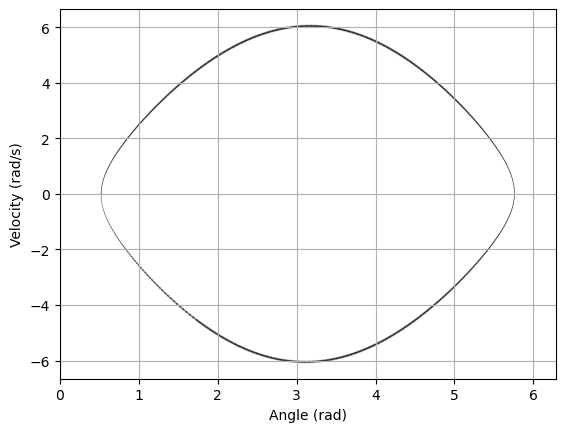

In [11]:
# Plot phase portrait with quivers
fig, ax = plt.subplots()
for qs, vs, _, _ in results:
    ax.quiver(qs[:-1], vs[:-1], qs[1:]-qs[:-1], vs[1:]-vs[:-1], scale_units='xy', angles='xy', scale=1, alpha=0.5)
ax.set_xlabel('Angle (rad)')
ax.set_ylabel('Velocity (rad/s)')
ax.set_xlim(0, 2*np.pi)
# ax.set_title('Phase Portrait (Variational Integrator)')
ax.grid()
plt.savefig('phase_portrait.png', dpi=300)

In [12]:
Ks, Ps = results[109][2], results[109][3]
fig, ax = plt.subplots()
ts = np.linspace(t0, tf, steps)

ax.plot(ts, Ks + Ps, label='Total Energy')
ax.plot(ts, Ks, label='Kinetic Energy')
ax.plot(ts, Ps, label='Potential Energy')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Energy (J)')
# ax.set_title('Energy Conservation (Variational Integrator)')
ax.legend()
ax.grid()

plt.savefig('energies_109.png', dpi=300)

IndexError: index 109 is out of bounds for axis 0 with size 1

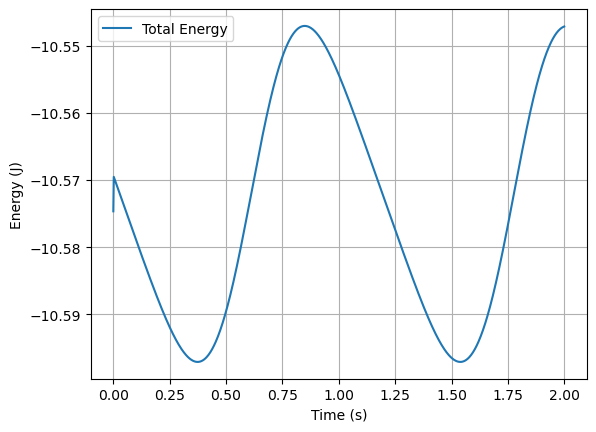

In [ ]:
Ks, Ps = results[109][2], results[109][3]
fig, ax = plt.subplots()
ts = np.linspace(t0, tf, steps)

ax.plot(ts, Ks + Ps, label='Total Energy')
# ax.plot(ts, Ks, label='Kinetic Energy')
# ax.plot(ts, Ps, label='Potential Energy')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Energy (J)')
# ax.set_title('Energy Conservation (Variational Integrator)')
ax.legend()
ax.grid()

plt.savefig('total_energy_109.png', dpi=300)

In [13]:
qs, vs, Ks, Ps = results[0]

In [14]:
ts = np.linspace(0, tf, int(tf / dt))

In [15]:
len(qs), tf

(1000, 10.0)

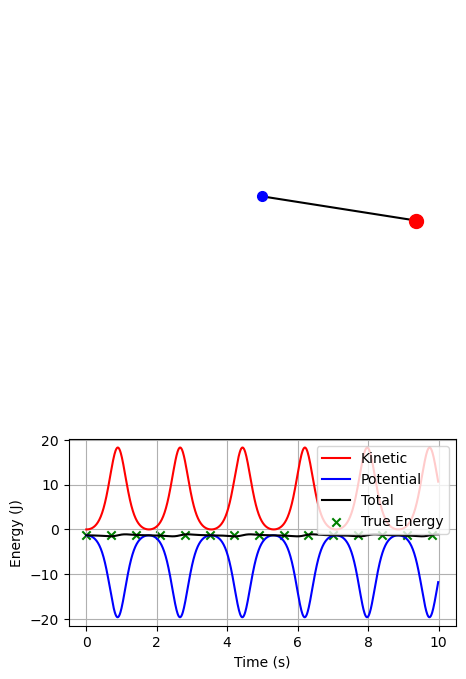

In [16]:
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots(2, 1, figsize=(5, 8), height_ratios=[4, 2])

# Set the x and y limits of the plot
ax[0].set_xlim(-1.2, 1.2)
ax[0].set_ylim(-1.2, 1.2)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_aspect("equal")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# Create a line object for the line between the points
(line1,) = ax[0].plot([], [], "black", linestyle='-')
ax[0].plot([0], [0], 'bo', markersize=7)
(mass,) = ax[0].plot([], [], 'ro', markersize=10)

(line3,) = ax[1].plot(ts, Ks, "red", linestyle='-', label='Kinetic')
(line4,) = ax[1].plot(ts, Ps, "blue", linestyle='-', label='Potential')
(line2,) = ax[1].plot(ts, Ks + Ps, "black", linestyle='-', label='Total')
gt = ax[1].scatter(ts[::70], ([Ks[0] + Ps[0]] * steps)[::70], color="green", marker='x', label='True Energy')

ax[1].grid()
ax[1].legend()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Energy (J)')

# Create a scatter plot for the points
# (points,) = ax.plot([], [], "ro")


# Animation update function
def update(frame):
    # Update the line and points data
    alpha = qs[frame][0]
    x = np.sin(alpha)
    y = np.cos(alpha)
    line1.set_data([0, x], [0, y])
    mass.set_data([x], [y])

    line3.set_data(ts[:frame], Ks[:frame])
    line4.set_data(ts[:frame], Ps[:frame])
    line2.set_data(ts[:frame], Ks[:frame] + Ps[:frame])
    # line2.set_data([x1[frame], x2[frame]], [y1[frame], y2[frame]])
    # points.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
    
    return line1, mass, line2

# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs), blit=True)

# Show the plot
animation.save("test.gif", writer="ffmpeg", fps=50, dpi=300)